## Customize settings 

In [2]:
# Imports and global settings
import matplotlib.pyplot as plt


#plt.rcParams({"font.size":10, "font.family": "Times New Roman"})

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
})

## Massage the data

In [3]:
from sklearn.datasets import fetch_openml
#Sets as_frame=False to get as a numpy array insted of pandasDF
mnist = fetch_openml("mnist_784", as_frame=False)


In [4]:
X,y= mnist.data, mnist.target

### Create test and train sets

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


### Create standarlized test and train sets to be able to tune the results if needed

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


## Defined functions

In [7]:
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import seaborn as sns
import numpy as np



#Gridsearch function, returns a grid search object.
def grid_search_function(model, param_grid, X_train, y_train,scoring="neg_root_mean_squared_error" ,cv=5):
    grid_search = GridSearchCV(model, param_grid,scoring=scoring, cv=cv)
    grid_search.fit(X_train, y_train)
    return grid_search

#classification report, returns a report object. 
def generate_classification_report(y,X, grid_search):
    y_predictec = grid_search.best_estimator_.predict(X)
    report = classification_report(y, y_predictec)
    return report

#Plots a confusion matrix with seaborn
def plot_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)   
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_precision_recall_curve(y_test, X_test, grid_search):
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    # Compute the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    # Calculate the average precision score
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1])
    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.show()

def plot_roc_curve(X_test, y_test, grid_search):
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    # Compute the fpr and tpr for all thresholds of the classification model
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

#plot learning curve
def plot_learning_curve(grid_search, X, y, title, cv=5, scoring='scoring="neg_root_mean_squared_error"', train_sizes=np.linspace(0.1, 1.0, 5)):
    
    # Extract the best model from the grid search
    best_model = grid_search.best_estimator_
    # Use sklearn's learning curve method to get the training and validation scores
    train_sizes, train_scores, valid_scores = learning_curve(best_model, X, y, cv=cv, scoring=scoring, 
                                                             train_sizes=train_sizes, n_jobs=-1)
    # If/else statment that returns positive or negative values depending on the name of the scoring variable
    if scoring.startswith('neg_'):
        train_scores_mean = -np.mean(train_scores, axis=1)
        valid_scores_mean = -np.mean(valid_scores, axis=1)
    else:
        train_scores_mean = np.mean(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)

    # Calculate the mean and standard deviation of the training and validation scores
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label=f"Validation score")
    # Plot the std deviation for training and validation scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, 
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.title(f"Learning Curves for {title}")
    plt.xlabel("Training examples")
    plt.ylabel(f"Score {scoring}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()



## KNN Classifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_param_grid = [{
    'weights': ["uniform", "distance"], 
    'n_neighbors': [3, 4, 5, 6]
    }]


knn_grid_search = grid_search_function(knn_clf, knn_param_grid,X_train[:10000],y_train[:10000], scoring="accuracy")

#Stores the test score
knn_grid_train_score = knn_grid_search.best_estimator_.score(X_train,y_train)
#The gridseach tested only the first 10 000, The next row wont be needed if the gridserch 
#uses the whole test set.
knn_grid_search.best_estimator_.fit(X_train, y_train)
knn_tuned_accuracy = knn_grid_search.score(X_test, y_test)
knn_tuned_accuracy


0.9714

Print out the best score and best estimators

In [9]:

print(f"The best parameters: {knn_grid_search.best_params_}")
print(f"The best accuarcy: {round(knn_tuned_accuracy* 100,2)} %")

The best parameters: {'n_neighbors': 4, 'weights': 'distance'}
The best accuarcy: 97.14 %


Create a report 

In [10]:
knn_report = generate_classification_report(y_test, X_test, knn_grid_search)
print(knn_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.97      0.96      1028
           8       0.99      0.94      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Plot confusion matrix

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

y_train_pred_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3)

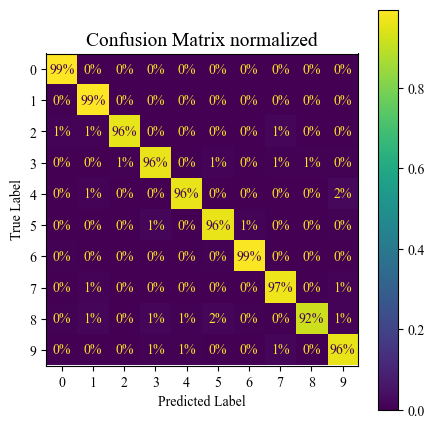

In [12]:

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_knn, normalize="true", values_format=".0%", ax=ax)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Confusion Matrix normalized', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

Plot the errors per row

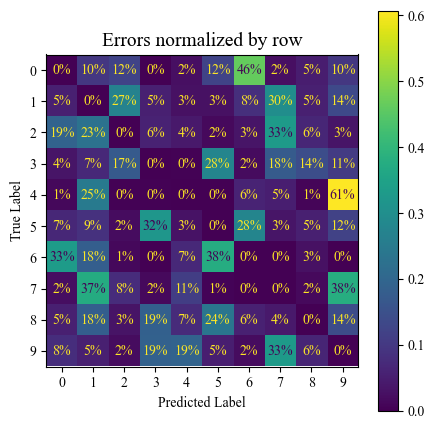

In [13]:
sample_weight = (y_train_pred_knn != y_train)
# extra code – this cell generates and saves Figure 3–10

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_knn, normalize="true", values_format=".0%", ax=ax, sample_weight=sample_weight)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Errors normalized by row', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

## SGD Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_param_grid = {
    'loss': ['hinge', 'log'],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.05],
    'power_t': [0.25, 0.5, 0.75]
}
sgd_grid_search = grid_search_function(sgd_clf, sgd_param_grid,X_train_scaled[:10000],y_train[:10000], scoring="accuracy")


#The gridseach tested only the first 10 000, Following rows wont be needed if the gridserch 
#uses the whole test set.
sgd_grid_search.best_estimator_.fit(X_train_scaled, y_train)
sgd_tuned_accuracy = sgd_grid_search.score(X_test_scaled, y_test)
sgd_tuned_accuracy


Print out the best score and best estimators

In [31]:

print(f"The best parameters: {sgd_grid_search.best_params_}")
print(f"The best accuarcy: {round(sgd_tuned_accuracy* 100,2)} %")

The best parameters: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2', 'power_t': 0.25}
The best accuarcy: 89.58 %


Create a report 

In [32]:
sgd_report = generate_classification_report(y_test, X_test_scaled, sgd_grid_search)
print(sgd_report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.96      0.97      1135
           2       0.94      0.87      0.91      1032
           3       0.92      0.87      0.89      1010
           4       0.94      0.89      0.92       982
           5       0.91      0.80      0.85       892
           6       0.95      0.92      0.93       958
           7       0.95      0.90      0.93      1028
           8       0.61      0.92      0.74       974
           9       0.93      0.85      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.90      0.90     10000



Plot confusion matrix

In [33]:

y_train_pred_sgd = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

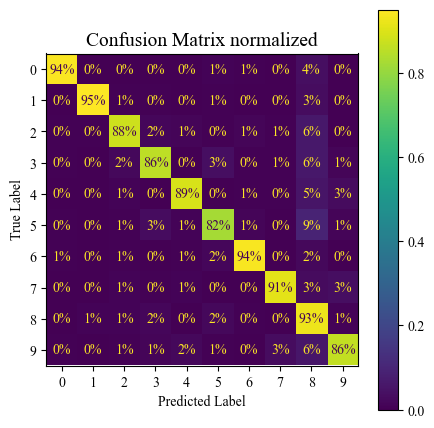

In [34]:

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_sgd, normalize="true", values_format=".0%", ax=ax)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Confusion Matrix normalized', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

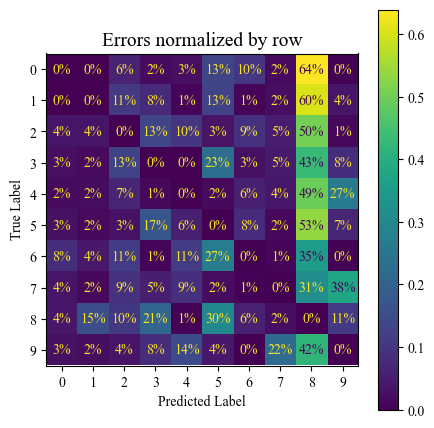

In [35]:
sample_weight = (y_train_pred_sgd != y_train)
# extra code – this cell generates and saves Figure 3–10

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_sgd, normalize="true", values_format=".0%", ax=ax, sample_weight=sample_weight)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Errors normalized by row', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier()
#random_forest_param_grid = [{
#    'n_estimators': [50,100,2000],
#    'max_depth': [10,20,30,None],
#    'min_samples_split': [2,5,10]
#     }]
random_forest_param_grid = [{
    'n_estimators': [2000],
    'max_depth': [20],
    'min_samples_split': [2]
     }]
random_forest_grid_search = grid_search_function(random_forest_clf, random_forest_param_grid,X_train[:10000],y_train[:10000], scoring="accuracy")

#The gridseach tested only the first 10 000, Following rows wont be needed if the gridserch 
#uses the whole test set.
random_forest_grid_search.best_estimator_.fit(X_train, y_train)
random_forest_tuned_accuracy = random_forest_grid_search.score(X_test, y_test)
random_forest_tuned_accuracy


0.9709

Print out the best score and best estimators

In [16]:

print(f"The best parameters: {random_forest_grid_search.best_params_}")
print(f"The best accuarcy: {round(random_forest_tuned_accuracy* 100,2)} %")

The best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 2000}
The best accuarcy: 97.09 %


Create a report 

In [17]:
random_forest_report = generate_classification_report(y_test, X_test, random_forest_grid_search)
print(random_forest_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Plot confusion matrix

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred_random_forest = cross_val_predict(random_forest_clf, X_train, y_train, cv=3)

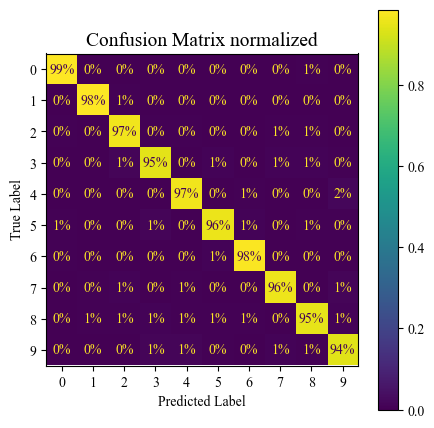

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_random_forest, normalize="true", values_format=".0%", ax=ax)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Confusion Matrix normalized', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

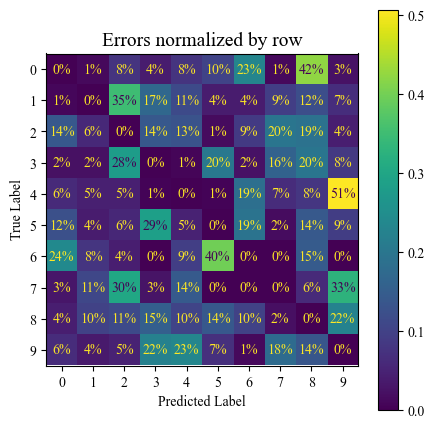

In [20]:
sample_weight = (y_train_pred_random_forest != y_train)
# extra code – this cell generates and saves Figure 3–10

fig, ax = plt.subplots(figsize=(5,5))
diplay = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_random_forest, normalize="true", values_format=".0%", ax=ax, sample_weight=sample_weight)

ax.set_xlabel('Predicted Label', fontsize=10)  # Override font size for xlabel
ax.set_ylabel('True Label', fontsize=10)       # Override font size for ylabel
ax.set_title('Errors normalized by row', fontsize=14)  # Override font size for title
ax.tick_params(axis='both', which='major', labelsize=10)  # Override tick label size

# Reduce font size of values inside the confusion matrix
for text in diplay.text_.ravel():
    text.set_fontsize(10)

# Adjust color bar to be smaller and reposition it
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

# Adjust layout to prevent overlapping and give more room for the plot
plt.subplots_adjust(left=0.1, right=0.88, top=0.9, bottom=0.1)

plt.show()

## Compare KNN with Random Forest using Confusion Matrix and diff values

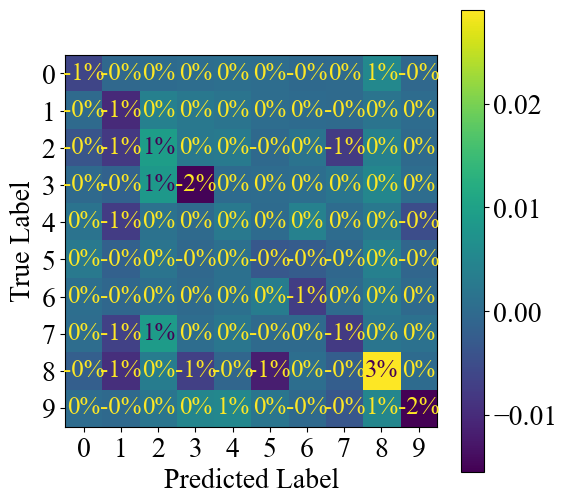

<Figure size 800x600 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrices for KNN and Random Forest
cm_knn = confusion_matrix(y_train, y_train_pred_knn, normalize="true")
cm_rf = confusion_matrix(y_train, y_train_pred_random_forest, normalize="true")

# Calculate the difference matrix
cm_diff = cm_rf - cm_knn

# Plot the difference matrix
fig, ax = plt.subplots(figsize=(6, 6))

# Display the difference matrix
display_diff = ConfusionMatrixDisplay(cm_diff)
display_diff.plot(cmap="viridis", values_format=".0%", ax=ax)
plt.figure(figsize=(8, 6))
# Set title and labels

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
cbar = diplay.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Set the tick label size for the color bar
cbar.ax.set_position([0.92, 0.3, 0.02, 0.4])  # Adjust the position: [left, bottom, width, height]

plt.tight_layout()
plt.show()